# Setting up GPU runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.3 MB/s 
     |████████████████████████████████| 376 kB 11.3 MB/s 
     |████████████████████████████████| 58 kB 8.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=b42fc8c9c1f058035fddcbd85f927e6974f910efefc6df213e43825164d8facf
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0bd2f25e2a1c29052272c5c3f463226fd66c9ba88979dfaaa3d9904c794f07ab
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 34.73 MiB/s, done.
Resolving deltas: 100% (3/3), done.


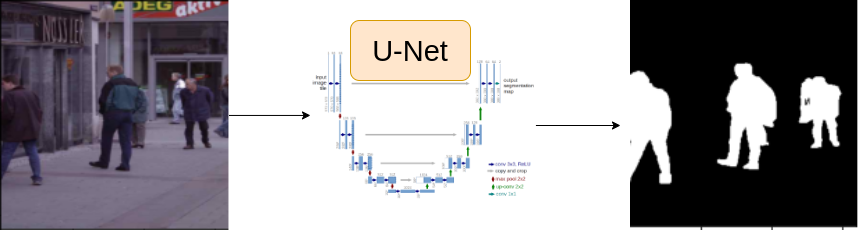

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setting up Configurations

In [ ]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'

device = 'cuda'
epochs = 25
lr = 0.003
img_size = 320
batch_size = 16
encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [ ]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[111]
image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

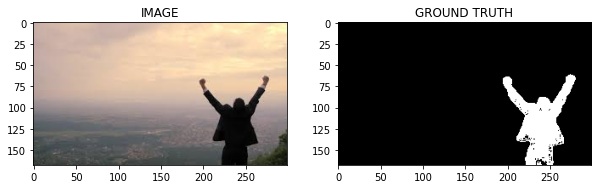

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
print("dataset", df.shape)
print("train dataset = ",train_df.shape)
print("test dataset = ", valid_df.shape)

dataset (290, 2)
train dataset =  (232, 2)
test dataset =  (58, 2)


# Creating Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
                    A.Resize(img_size, img_size),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(img_size, img_size),
  ])

# Creating Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):

    row = self.df.iloc[idx]
    
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)
    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.tensor(image) / 255.0
    mask = torch.round(torch.tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


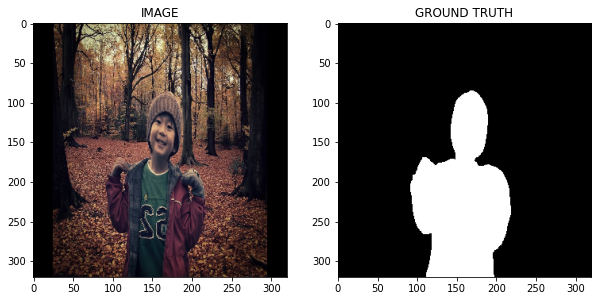

In [ ]:
idx = 21
image, mask = trainset[idx]
helper.show_image(image, mask)

# Loading dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Creating Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if  masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    
    return logits

In [ ]:
model = SegmentationModel()
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)
      
      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
best_valid_loss = np.Inf

for epoch in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("THE MODEL HAS BEEN SAVED")
    best_valid_loss = valid_loss

  print(f"Epoch : {epoch + 1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


THE MODEL HAS BEEN SAVED
Epoch : 1 Train Loss : 0.8952293793360392 Valid Loss : 0.8062912672758102


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


THE MODEL HAS BEEN SAVED
Epoch : 2 Train Loss : 0.3950587491194407 Valid Loss : 0.4886019453406334


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch : 3 Train Loss : 0.3016758143901825 Valid Loss : 0.636158749461174


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


THE MODEL HAS BEEN SAVED
Epoch : 4 Train Loss : 0.2723308275143305 Valid Loss : 0.268252857029438


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


THE MODEL HAS BEEN SAVED
Epoch : 5 Train Loss : 0.2519142091274261 Valid Loss : 0.20183969661593437


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch : 6 Train Loss : 0.22294847369194032 Valid Loss : 0.22793901711702347


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 7 Train Loss : 0.23859788378079733 Valid Loss : 0.2451050467789173


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 8 Train Loss : 0.22617835104465484 Valid Loss : 0.2167741283774376


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 9 Train Loss : 0.16391118218501408 Valid Loss : 0.2457161620259285


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 10 Train Loss : 0.21286344826221465 Valid Loss : 0.2844206988811493


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 11 Train Loss : 0.20893606344858806 Valid Loss : 0.2631736323237419


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


THE MODEL HAS BEEN SAVED
Epoch : 12 Train Loss : 0.1714588612318039 Valid Loss : 0.1897892951965332


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 13 Train Loss : 0.13575589656829834 Valid Loss : 0.1983073651790619


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 14 Train Loss : 0.11855270961920421 Valid Loss : 0.22192490473389626


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Epoch : 15 Train Loss : 0.1437362551689148 Valid Loss : 0.26149294897913933


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 16 Train Loss : 0.14777126957972844 Valid Loss : 0.2392606884241104


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 17 Train Loss : 0.14292498876651127 Valid Loss : 0.19354868307709694


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch : 18 Train Loss : 0.15489739378293355 Valid Loss : 0.19162669777870178


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


THE MODEL HAS BEEN SAVED
Epoch : 19 Train Loss : 0.13221903393665949 Valid Loss : 0.1782886665314436


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 20 Train Loss : 0.12265646507342656 Valid Loss : 0.22217447310686111


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


THE MODEL HAS BEEN SAVED
Epoch : 21 Train Loss : 0.11097764819860459 Valid Loss : 0.1606907844543457


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 22 Train Loss : 0.0967396005988121 Valid Loss : 0.16464171186089516


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


THE MODEL HAS BEEN SAVED
Epoch : 23 Train Loss : 0.10005084872245788 Valid Loss : 0.15334855392575264


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch : 24 Train Loss : 0.1366821805636088 Valid Loss : 0.18936502933502197


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

Epoch : 25 Train Loss : 0.11809556980927785 Valid Loss : 0.3123198915272951


# Inference

In [ ]:
idx = 3

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
# print(image.shape)
# import cv2
# image = cv2.imread("/content/person.jpeg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = np.transpose(image, (2,0,1)).astype(np.float32)
# image = torch.tensor(image) / 255.0
# print(image.shape)
# print(image)


logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

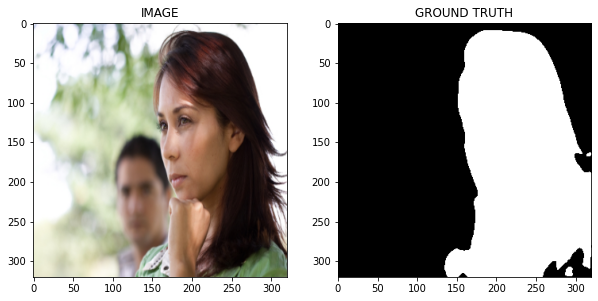

In [ ]:
helper.show_image(image, pred_mask.detach().cpu().squeeze(0))